## [ 산불 감지 이진 분류 CNN 모델 ]
#### - CNN NoFire / Not_NoFire 분류 모델

[1] 모듈 로딩 및 데이터 준비<hr>

In [42]:
## 모듈 로딩
import torch                                        ## Tensor 및 기본 함수들 관련 모듈
import torch.nn as nn                               ## 인공신경망 관련 모듈
import torch.nn.functional as F # type: ignore
import torch.optim as optim 
from   torch.optim.lr_scheduler import ReduceLROnPlateau
from   torchmetrics.classification import *

from torchvision.datasets import ImageFolder       ## 비젼관련 내장 데이터셋 모듈
from torch.utils.data import DataLoader             ## Pytorch의 데이터셋 관련 모듈
from torchinfo import summary                       ## 모델 구조 및 정보 확인 모듈

import torchvision.transforms as transforms         ## 비젼관련 이미지 증강/변환 관련 모듈

import matplotlib.pyplot as plt                     ## 이미지 시각화 

import torchvision.models as models

In [43]:
IMG_ROOT_tr = '../MINIPROJECT10/data/image/DATASET/train/'       ## 이미지 데이터 저장 폴더 경로
IMG_ROOT_ts = '../MINIPROJECT10/data/image/DATASET/test/'
IMG_ROOT_va = '../MINIPROJECT10/data/image/DATASET/val/'

[2] 데이터 로딩 <hr>

In [44]:
## 데이터 변환 설정
preprocessing = transforms.Compose(
    [
        transforms.Resize((50,50)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

## 데이터셋 로드
trainDS = ImageFolder(IMG_ROOT_tr,transform=preprocessing)
testDS  = ImageFolder(IMG_ROOT_ts,transform=preprocessing)
validDS = ImageFolder(IMG_ROOT_va,transform=preprocessing)

# ## 데이터셋 섞기
# trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
# testDL  = DataLoader(testDS, batch_size=32, shuffle=False)
# validDL = DataLoader(validDS, batch_size=32, shuffle=False) 

In [45]:
## 데이터셋 체크
## - 타입
print(f'type         : {type(trainDS)}')

## - 속성 : 클래스 정보
print(f'classes      : {trainDS.classes}')
print(f'class_to_idx : {trainDS.class_to_idx}')

type         : <class 'torchvision.datasets.folder.ImageFolder'>
classes      : ['nofire', 'not_nofire']
class_to_idx : {'nofire': 0, 'not_nofire': 1}


In [46]:
## 데이터셋 체크
## - 타입
print(f'type         : {type(testDS)}')

## - 속성 : 클래스 정보
print(f'classes      : {testDS.classes}')
print(f'class_to_idx : {testDS.class_to_idx}')

type         : <class 'torchvision.datasets.folder.ImageFolder'>
classes      : ['nofire', 'not_nofile']
class_to_idx : {'nofire': 0, 'not_nofile': 1}


In [47]:
## 데이터셋 체크
## - 타입
print(f'type         : {type(validDS)}')

## - 속성 : 클래스 정보
print(f'classes      : {validDS.classes}')
print(f'class_to_idx : {validDS.class_to_idx}')

type         : <class 'torchvision.datasets.folder.ImageFolder'>
classes      : ['nofire', 'not_nofire']
class_to_idx : {'nofire': 0, 'not_nofire': 1}


In [48]:
# ## - 속성 : 데이터와 타겟
# print(f'targets      : {testDS.targets} {len(trainDS.classes)}')
# print(f'data         : {testDS.samples.shape}')

In [49]:
testDS[0]

(tensor([[[ 0.5451,  0.5451,  0.5451,  ...,  0.4196,  0.4196,  0.4118],
          [ 0.5765,  0.5765,  0.5765,  ...,  0.4196,  0.4118,  0.4039],
          [ 0.5529,  0.5529,  0.5608,  ...,  0.4196,  0.4118,  0.4118],
          ...,
          [-0.6549, -0.7569, -0.8039,  ..., -0.6314, -0.6078, -0.6549],
          [-0.7176, -0.8275, -0.8353,  ..., -0.7490, -0.6784, -0.7961],
          [-0.7961, -0.8275, -0.8353,  ..., -0.8039, -0.7412, -0.8196]],
 
         [[-0.0039, -0.0039, -0.0039,  ..., -0.0980, -0.0980, -0.1059],
          [ 0.0275,  0.0275,  0.0275,  ..., -0.0980, -0.1059, -0.1137],
          [ 0.0039,  0.0039,  0.0118,  ..., -0.0980, -0.1059, -0.1059],
          ...,
          [-0.6314, -0.7412, -0.7882,  ..., -0.6392, -0.6000, -0.6392],
          [-0.6941, -0.8118, -0.8196,  ..., -0.7412, -0.6627, -0.7804],
          [-0.7804, -0.8118, -0.8196,  ..., -0.7961, -0.7333, -0.8118]],
 
         [[-0.6941, -0.6941, -0.6941,  ..., -0.6784, -0.6784, -0.6863],
          [-0.6627, -0.6627,

In [50]:
## CNN MODEL -----------------------------------------------------------------------
## 클래스이름 : FashionDNN
## 부모클래스 : nn.Module
## 모델구현법 : 지도학습 + 다중 분류 
## 모델층 구성  입력피쳐/신호     출력/퍼셉트론수    활성화함수
## 입  력  층       784             512             ReLu
## 은  닉  층       512             256             ReLu
## 은  닉  층       256             130             ReLu
## 출  력  층       130             10               X
## ----------------------------------84----------------------------------------------
class NoFireForestCNN(nn.Module):
    def __init__(self, isDebug=False):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(4608, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    ## 순방향 학습 진행 메서드 
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = self.fc_layers(x)
        return x

[4] 학습 준비 <hr>

In [62]:
## 학습 설정
EPOCHS      = 100                                                                                   ### 몇 번 학습
BATCH_SIZE  = 128                                                                                   ### 몇 개씩 학습  ### 너무 작아도 안 되고 많아도 안 됨
T_ITERATION = int(len(trainDS)/BATCH_SIZE)
V_ITERATION = int(len(validDS)/BATCH_SIZE)                                                  ### 밸리데이션 데이터 있으면 testDS 대신 넣기

## 최적화 설정
LR          = 0.0005                       ## W,b 업데이터 간격 조절
PAT_CNT     = 3                          ## 모델 성능 미개선 참을 수 있는 수 횟수                  ### 러닝레이트 조절 부분
CLASSES     = len(trainDS.classes)

## 학습 및 데이터 로딩 실행 위치/저장 위치
DEVICE      = 'gpu' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')                                                                        ### 기기 체크

DEVICE => cpu


In [63]:
## 인스턴스 생성
GEN         = torch.Generator().manual_seed(42)     ## 랜덤 시드 고정
TRAINDL     = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, generator=GEN)           ### 필요한 만큼만 꺼내주는 친구 
TESTDL      = DataLoader(testDS,  batch_size=BATCH_SIZE, shuffle=False, generator=GEN)
VALIDDL     = DataLoader(validDS, batch_size=BATCH_SIZE, shuffle=False, generator=GEN)
## 모델과 최적화 관련
MODEL       = NoFireForestCNN()      ### True : 디버깅용 
OPTIMIZER   = optim.Adam(MODEL.parameters(), lr=LR)                                  ### lr : 간격 너무 커도 안 되고 작아도 안 됨 조절해야 함
SCHEDULER   = ReduceLROnPlateau(OPTIMIZER, mode='min', patience=PAT_CNT)             ### 간격을 알아서 조절해서 가게 해주는 것 : 스케줄러  ###로스가 안 줄고 제자리 왔다갔다 해 몇 번 참을래 : patience 기본값은 10번(지금까지 해보니 그게 제일 낫더라라)

## 손실함수, 모델성능평가 관련 함수 인스턴스
LOSS_FN     = nn.BCEWithLogitsLoss()
SCORE_FN    = BinaryAccuracy()
# SCORE_FN    = MulticlassF1Score(num_classes=CLASSES)

## 클래스 라벨 반환 딕셔너리
IDX_TO_CLASSES = {v:k for k, v in trainDS.class_to_idx.items()}

In [64]:
## 학습 관련 함수
## --------------------------------------------------------------
## - 검증 함수 : 테스트 또는 검증용 데이터셋 사용하는 함수 
##              W,b 업데이트 안함
## --------------------------------------------------------------
def evaluate(model, testDL, loss_fn, score_fn, n_iter):
    # 에포크 단위로 검증 => 검증 모드
    model.eval()

    # W, b가 업데이트 해제
    with torch.no_grad():
        T_LOSS, T_ACC = 0, 0
        T_PREC, T_REC, T_F1 = 0, 0, 0   # Precision, Recall, F1-score 추가
        
        for feature, target in testDL:
            # 학습 진행
            pre_y = model(feature)

            # 손실 계산
            loss = loss_fn(pre_y, target.reshape(-1,1).float())
            
            # 정확도 계산
            acc = score_fn(pre_y, target.reshape(-1,1))
            precision = Precision(task="binary")(pre_y, target.reshape(-1,1))
            recall = Recall(task="binary")(pre_y, target.reshape(-1,1))
            f1 = F1Score(task="binary")(pre_y, target.reshape(-1,1))

            T_LOSS += loss.item()
            T_ACC  += acc.item()
            T_PREC += precision.item()
            T_REC  += recall.item()
            T_F1   += f1.item()

    return T_LOSS/n_iter, T_ACC/n_iter, T_PREC/n_iter, T_REC/n_iter, T_F1/n_iter
  

In [65]:
## 학습 관련 함수
## --------------------------------------------------------------
## - 학습 함수 : 학습 데이터셋 사용하는 함수 
##              W,b 업데이트 진행
## --------------------------------------------------------------
def training(model, trainDL, optimizer, loss_fn, score_fn, n_iter):
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    for feature, target in trainDL:
        # 배치크기만큼 feature, target로딩

        # print("Feature Shape:", feature.shape)
        

        # 가중치 기울기 0 초기화
        optimizer.zero_grad()

        # 학습 진행
        pre_y = model(feature)

        # 손실 계산
        loss = loss_fn(pre_y, target.reshape(-1,1).float())
        
        # 성능 : 정확도 계산 (or F1)
        acc = score_fn(pre_y, target.reshape(-1,1))

        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        optimizer.step()

        E_LOSS += loss.item()               ### item 안 하면 tensor 들어가서 값 안 나와서 그래프 못 그림
        E_ACC  += acc.item()

    return E_LOSS/n_iter, E_ACC/n_iter

-> 학습 진행: 모델 또는 가중치 저장 + 조기 종료 : 파이토치에는 없음 만들어 줘야 함

In [66]:
## 모델 경로 설정
MODEL_DIR  = './models/'
MODEL_FILE = 'fashionModel.pt'
# MODEL_FILE = 'fashion_epoch8_0.907.pt'

In [67]:
## 학습 관련 모듈 로딩
# from utils import * 

# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}  

# 모델 저장 위한 기준값 저장 변수
BEST_ACC   = 0

# 조기 종료 위한 기준값 저장 변수
EARLY_STOP = 3

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training(MODEL, TRAINDL, OPTIMIZER, LOSS_FN, SCORE_FN, T_ITERATION)
    validLoss, validAcc, validPrec, validRec, validF1 = evaluate(MODEL, VALIDDL, LOSS_FN, SCORE_FN, V_ITERATION)               ### min => Loss, max => Acc

    ## 모델 저장
    # if BEST_ACC < validAcc:   # 0 < 0.1212  ==>  0.1212 < 현재 valacc
    #     #torch.save(MODEL, MODEL_DIR+MODEL_FILE)
    #     torch.save(MODEL, f'{MODEL_DIR}fashion_epoch{epoch}_{validAcc:.3f}.pt')
    #     BEST_ACC = validAcc

    ## 모델 층별 가중치+바이어스 저장
    if BEST_ACC < validAcc:   # 0 < 0.1212  ==>  0.1212 < 현재 valacc
        #torch.save(MODEL.state_dict(), MODEL_DIR+MODEL_FILE)
        torch.save(MODEL.state_dict(), f'{MODEL_DIR}fashion_weights_epoch{epoch}_{validAcc:.3f}.pt')
        BEST_ACC = validAcc


    ## 학습 상태 저장
    HIST['Train'][0].append(trainLoss) 
    HIST['Train'][1].append(trainAcc) 
    
    HIST['Valid'][0].append(validLoss) 
    HIST['Valid'][1].append(validAcc) 


    ## 학습 상태 시각화
    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')
    print(f'- PRECISION {validPrec:.5f}  RECALL {validRec:.5f}  F1-SCORE {validF1:.5f}')

    ## 조기종료 체크
    SCHEDULER.step(validLoss)   ### 

    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:            ### 카운팅이 들어감
        EARLY_STOP -= 1

    if not EARLY_STOP:
        print(f'{epoch+1} - EPOCHS : 성능 개선이 없어서 조기 종료합니다.')    ### 여기까지 구하고 다시 할 때는 진행했던 곳부터 진행         




EPOCH[1/100]----------------
- TRAIN_LOSS 0.66873  ACC 0.67773
- VALID_LOSS 0.64667  ACC 1.00521
- PRECISION 0.96237  RECALL 0.71801  F1-SCORE 0.79988

EPOCH[2/100]----------------
- TRAIN_LOSS 0.49939  ACC 0.87044
- VALID_LOSS 0.49943  ACC 1.15104
- PRECISION 0.96774  RECALL 0.87760  F1-SCORE 0.91239

EPOCH[3/100]----------------
- TRAIN_LOSS 0.41425  ACC 0.91927
- VALID_LOSS 0.42660  ACC 1.16927
- PRECISION 0.96237  RECALL 0.91071  F1-SCORE 0.93217

EPOCH[4/100]----------------
- TRAIN_LOSS 0.37325  ACC 0.93424
- VALID_LOSS 0.46990  ACC 1.17188
- PRECISION 0.97576  RECALL 0.87128  F1-SCORE 0.91797

EPOCH[5/100]----------------
- TRAIN_LOSS 0.37038  ACC 0.93815
- VALID_LOSS 0.42346  ACC 1.18229
- PRECISION 0.97740  RECALL 0.90030  F1-SCORE 0.93382

EPOCH[6/100]----------------
- TRAIN_LOSS 0.33484  ACC 0.95443
- VALID_LOSS 0.35620  ACC 1.22135
- PRECISION 0.96721  RECALL 0.95238  F1-SCORE 0.95783

EPOCH[7/100]----------------
- TRAIN_LOSS 0.31178  ACC 0.96484
- VALID_LOSS 0.33333  AC

KeyboardInterrupt: 

[7] 모델 활용 <hr>

In [75]:
## 방법-1) 저장된 모델 로딩
model = torch.load(MODEL_DIR+'fashion_weights_epoch11_1.242.pt', weights_only=False)
# model = torch.load(MODEL_DIR+'fashion_epoch2_0.907.pt', weights_only=False)
model

OrderedDict([('conv_layers.0.weight',
              tensor([[[[-0.1938,  0.1574, -0.1802],
                        [ 0.1241,  0.0430, -0.1701],
                        [-0.0597,  0.1721,  0.1362]],
              
                       [[ 0.0073, -0.1809, -0.0072],
                        [ 0.0212,  0.0552, -0.1408],
                        [ 0.1559,  0.1746,  0.0582]],
              
                       [[-0.0870,  0.1507, -0.0698],
                        [ 0.1240,  0.0392, -0.0807],
                        [-0.1658, -0.1543, -0.1735]]],
              
              
                      [[[ 0.0393,  0.1329, -0.1262],
                        [ 0.1459, -0.1629,  0.1289],
                        [ 0.1035,  0.1774, -0.0846]],
              
                       [[-0.1233,  0.0167,  0.1335],
                        [-0.0792,  0.0232, -0.1076],
                        [ 0.0086, -0.1003, -0.1316]],
              
                       [[-0.0920,  0.0987,  0.0473],
                  

In [76]:
## 데이터 변환 설정
preprocessing = transforms.Compose(
    [
        transforms.Resize((50,50)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

## 데이터셋 로드
trainDS = ImageFolder(IMG_ROOT_tr,transform=preprocessing)
testDS  = ImageFolder(IMG_ROOT_ts,transform=preprocessing)
validDS = ImageFolder(IMG_ROOT_va,transform=preprocessing)

# ## 데이터셋 섞기
# trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
# testDL  = DataLoader(testDS, batch_size=32, shuffle=False)
# validDL = DataLoader(validDS, batch_size=32, shuffle=False) 

In [77]:
# ## 방법-1) 저장된 모델 로딩

# from torchsummary import summary 
# model = torch.load(MODEL_DIR + 'fashion_weights_epoch18_0.922.pt', weights_only=False)
# summary(model, input_size=(3, 50, 50))

- 예측함수 

In [78]:
## 사용자 입력 데이터에 대한 전처리 즉, 모델에 입력되는 형태로 변환
preprocessing = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

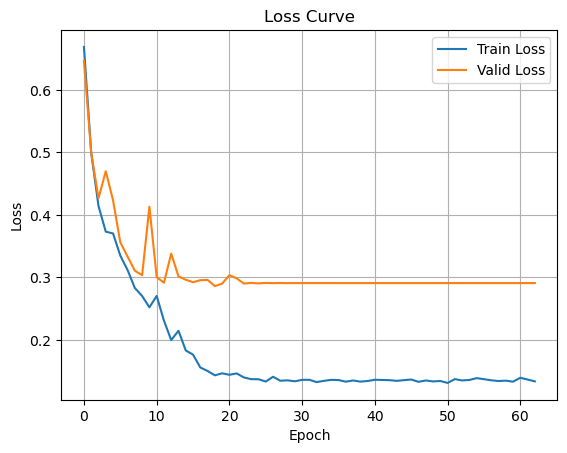

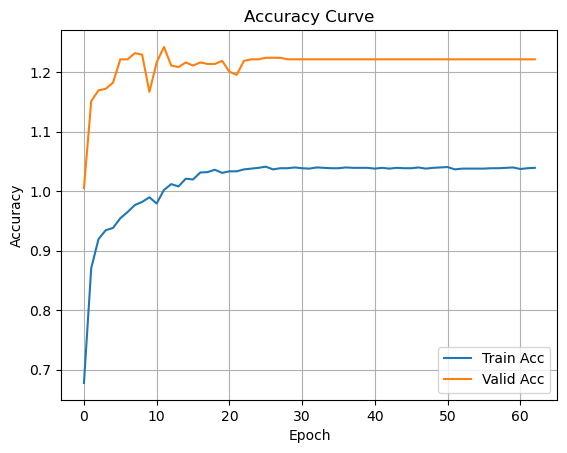

In [79]:
plt.plot(HIST['Train'][0], label='Train Loss')
plt.plot(HIST['Valid'][0], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.grid()
plt.show()

plt.plot(HIST['Train'][1], label='Train Acc')
plt.plot(HIST['Valid'][1], label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.grid()
plt.show()

In [80]:
# import joblib

# # 🔹 1️⃣ SVM 모델 저장
# joblib.dump(model, "../MINIPROJECT10/cgi-bin/nofireCNN_model.pkl")
# print("✅ 모델이 'nofireCNN_model.pkl'로 저장됨!")

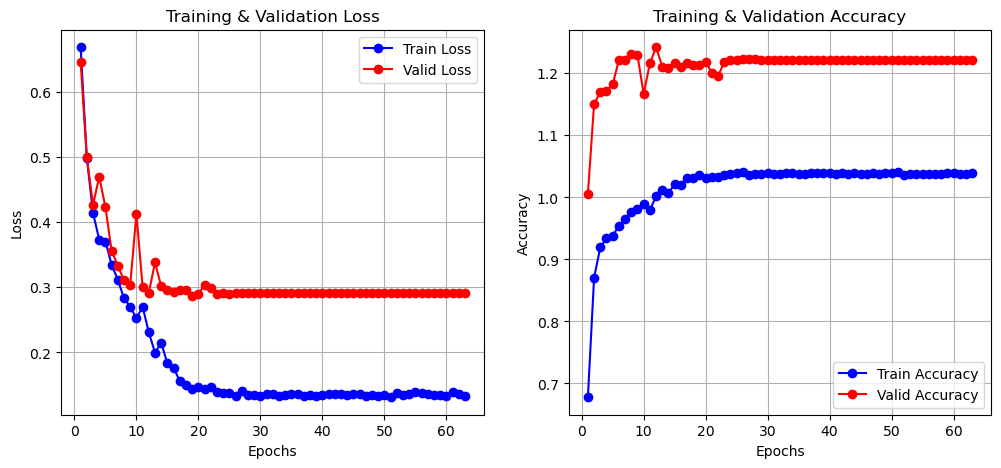

In [81]:
import matplotlib.pyplot as plt

def plot_training_curve(HIST):
    epochs = range(1, len(HIST['Train'][0]) + 1)

    # Loss 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, HIST['Train'][0], 'b-o', label="Train Loss")
    plt.plot(epochs, HIST['Valid'][0], 'r-o', label="Valid Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, HIST['Train'][1], 'b-o', label="Train Accuracy")
    plt.plot(epochs, HIST['Valid'][1], 'r-o', label="Valid Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()

# 학습 곡선 출력
plot_training_curve(HIST)

In [82]:
# ## 방법-1) 저장된 모델 로딩

WEIGHTS_FILE = MODEL_DIR+'fashion_weights_epoch11_1.242.pt'

model=NoFireForestCNN()
states=torch.load(WEIGHTS_FILE, weights_only=True)
model.load_state_dict(states)

<All keys matched successfully>

In [83]:
count = 0
for feature, target in testDS:
    feature = feature.unsqueeze(0)  # 배치 차원 추가 (1, C, H, W)
    output = model(feature)  # (1, 1)
    predicted = (output.sigmoid() > 0.5).long().squeeze()  # 0 또는 1 변환
    # print(predicted.item(), target)  # 정수 값 출력
    if predicted.item() == target:
        count+=1
print(count/len(testDS))

0.895


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# 1️⃣ 모델 정의 (가중치와 동일한 구조여야 함)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 1)  # 이진 분류 (출력 1개)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # 이진 분류이므로 sigmoid 사용
        return x

# 2️⃣ 저장된 가중치 불러오기
MODEL_PATH = "fashion_weights_epoch11_1.242.pt."  # 모델 가중치 파일 경로
model = MyModel()
state_dict = torch.load(MODEL_PATH, map_location=torch.device("cpu"))
model.load_state_dict(state_dict)  # 가중치 로드
model.eval()  # 평가 모드

# 3️⃣ 테스트 데이터셋 불러오기 (사용자가 직접 정의 필요)
testDS = ...  # 사용자가 정의한 데이터셋
test_loader = DataLoader(testDS, batch_size=32, shuffle=False)

# 4️⃣ 평가 함수
def evaluate_model(model, dataloader):
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    criterion = nn.BCELoss()  # Binary Cross Entropy Loss

    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features.to("cpu"), targets.to("cpu").float().unsqueeze(1)

            outputs = model(features)
            loss = criterion(outputs, targets)

            predicted = (outputs > 0.5).long()  # 0 또는 1로 변환

            total_loss += loss.item()
            correct += (predicted == targets.long()).sum().item()
            total_samples += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # 5️⃣ 성능 지표 계산
    accuracy = correct / total_samples
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    # 6️⃣ 결과 출력 (사진과 유사한 형식)
    print(f"EPOCH[12/100]------------------")
    print(f"- TRAIN_LOSS {total_loss:.5f}  ACC {accuracy:.5f}")
    print(f"- VALID_LOSS {total_loss:.5f}  ACC {accuracy:.5f}")
    print(f"- PRECISION {precision:.5f}  RECALL {recall:.5f}  F1-SCORE {f1:.5f}")

# 7️⃣ 모델 평가 실행
evaluate_model(model, test_loader)

C:\Users\KDP-31-\AppData\Local\Temp\ipykernel_28984\706166916.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=torch.dev

FileNotFoundError: [Errno 2] No such file or directory: 'fashion_weights_epoch11_1.242.pt.'